In [1]:
%autosave 60
%pip install --quiet -r requirements.txt

Autosaving every 60 seconds
Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_loader import DataLoader
from utils.data_converter import DataConverter
from utils.data_analyser import DataAnalyser
from models.unet_3d_std import UNet3D
from models.unet_3d_res import ResidualUNet3D
from utils.train_eval import fit_3D
from utils.loss_functions import ssim_loss, l1_loss

data_loader = DataLoader()
data_converter = DataConverter()
data_analyser = DataAnalyser()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Flush cuda memory

In [3]:
torch.cuda.empty_cache()

Common Variables

In [4]:
model_epochs            = 100
save_every              = 25
model_checkpoint_every  = 100

img_crop_axes = ((16, 10, 0), (17, 11, 17))

In [5]:
training_pairs, validation_pairs, test_pairs = data_loader.split_dataset_paths(seed=69) # Standard 70/20/10 split
print("We have", len(training_pairs), "training pairs")
print("We have", len(test_pairs), "test pairs")

We have 492 training pairs
We have 106 test pairs


## 3D U-Net

### Model Training

In [6]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"
unet = UNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [7]:
"""
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")
"""
print("TODO Re-implementer når ikke ass")

TODO Re-implementer når ikke ass


In [8]:
unet, unet_losses, unet_snapshots, unet_best = fit_3D(
    model=unet,
    device=device,
    training_pairs=training_pairs,
    validation_pairs=validation_pairs,
    epochs=model_epochs,
    loss_func=ssim_loss,
    dataConverter=data_converter,
    optimizer=unet_optimizer,
    save_every=save_every,
    checkpoint_every=model_checkpoint_every,
    crop_axes=img_crop_axes,
)

Training 3D Residual U-Net:   0%|          | 0/100 [00:00<?, ?it/s]

Training 3D Residual U-Net: 100%|██████████| 100/100 [04:18<00:00,  2.58s/it, Best loss on val 0.525381, (Iter 99)]


Displaying snapshot from pair 0, loss: 0.9429


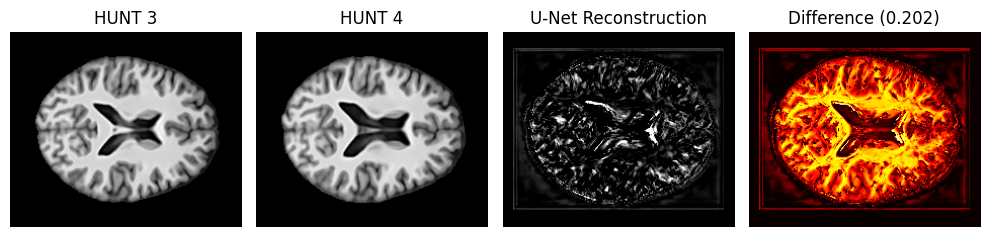

Displaying snapshot from pair 25, loss: 0.4703


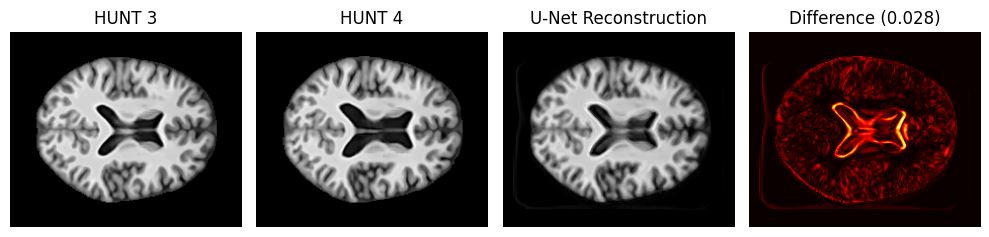

Displaying snapshot from pair 50, loss: 0.5178


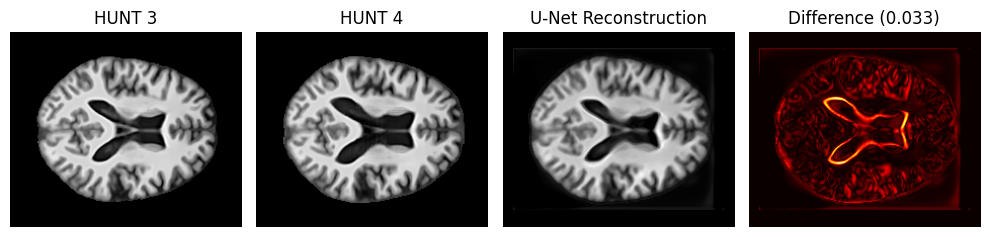

Displaying snapshot from pair 75, loss: 0.6157


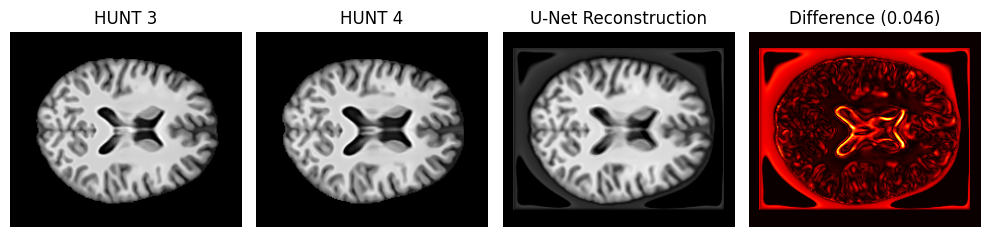

Displaying snapshot from pair 99, loss: 0.5562


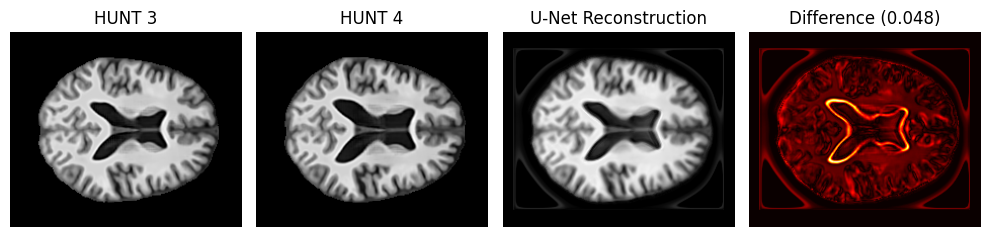

In [9]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_analyser.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [10]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unets/3d_unet_model_standard.pt


### Model Evaluation over Testset

In [11]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"

# Import model before testing
unet = UNet3D(in_ch=1, base=32).to(device)
unet.load_state_dict(torch.load(unet_path))
print("Loaded trained model for testing.")

Loaded trained model for testing.


In [12]:
unet.eval()
avg_unet_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input_full, target_full = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    input, target = data_converter.get_volume_with_3d_change(tensor=input_full, crop_axes=img_crop_axes, remove_mode=True), data_converter.get_volume_with_3d_change(tensor=target_full, crop_axes=img_crop_axes, remove_mode=True)

    # Get Reconstructions
    unet_recon = unet(input)
    target_num = target

    # calculate 3d loss
    avg_unet_loss += ssim_loss(unet_recon, target_num).item()

avg_unet_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")

# We save the model with the test loss in the filename for easy identification
test_unet_path = f"{output_dir}/3d_unet_model_standard_testloss_{avg_unet_loss:.4f}.pt"
torch.save(unet.state_dict(), test_unet_path)
print(f"Test model saved to {test_unet_path}")

  1%|          | 1/106 [00:00<01:43,  1.02it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.40 GiB. GPU 0 has a total capacity of 39.49 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 38.14 GiB memory in use. Of the allocated memory 37.33 GiB is allocated by PyTorch, and 331.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Residual 3D U-Net

### Model Training

In [ ]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_res_unet_model.pt"
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

No existing 3D U-Net found, starting fresh training.
492 training pairs


In [ ]:
unet, unet_losses, unet_snapshots, unet_best = fit_3D(
    model=unet,
    device=device,
    training_pairs=training_pairs,
    validation_pairs=validation_pairs,
    epochs=model_epochs,
    loss_func=ssim_loss,
    dataConverter=data_converter,
    optimizer=unet_optimizer,
    save_every=save_every,
    checkpoint_every=model_checkpoint_every,
    crop_axes=img_crop_axes,
)

Training 3D Residual U-Net:   0%|          | 0/250 [00:00<?, ?it/s]

Training 3D Residual U-Net: 100%|██████████| 250/250 [09:26<00:00,  2.27s/it, Best loss on val 0.108318, (Iter 249)]


Displaying snapshot from pair 0, loss: 0.8511


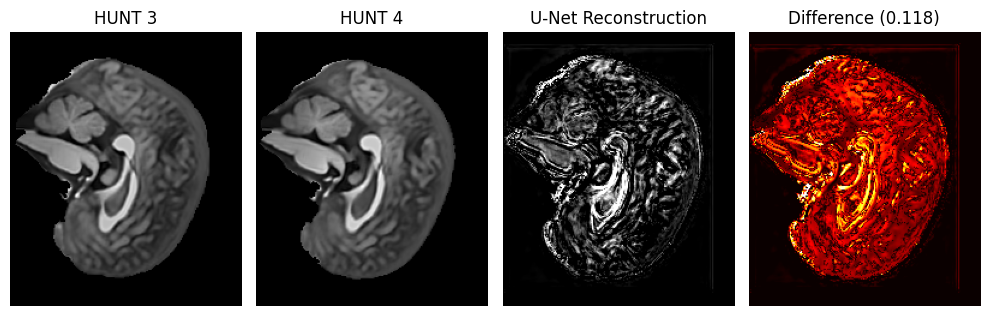

Displaying snapshot from pair 50, loss: 0.6425


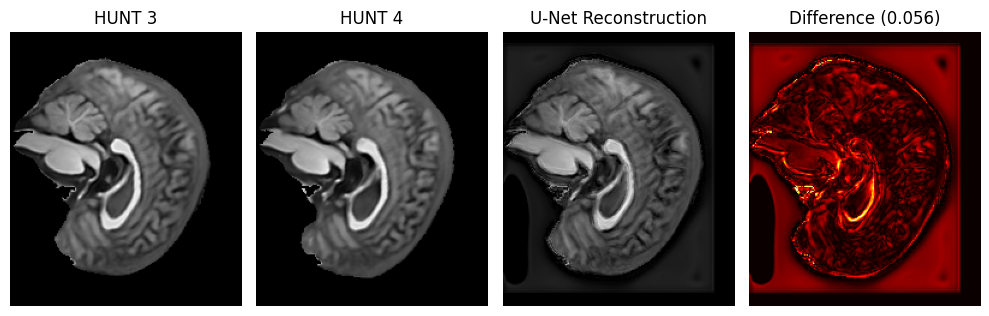

Displaying snapshot from pair 100, loss: 0.6574


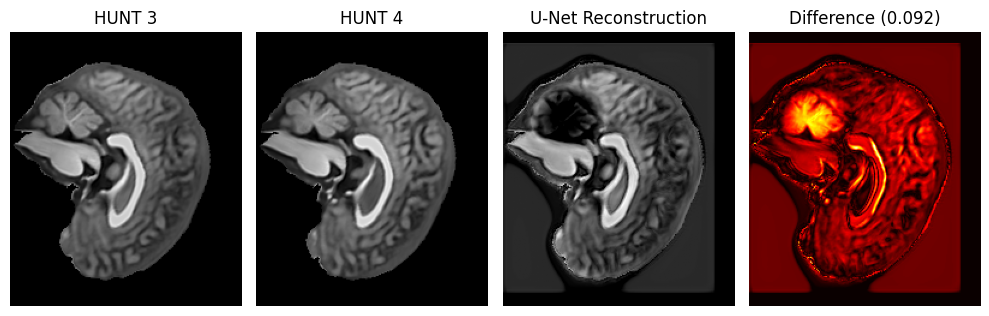

Displaying snapshot from pair 150, loss: 0.5270


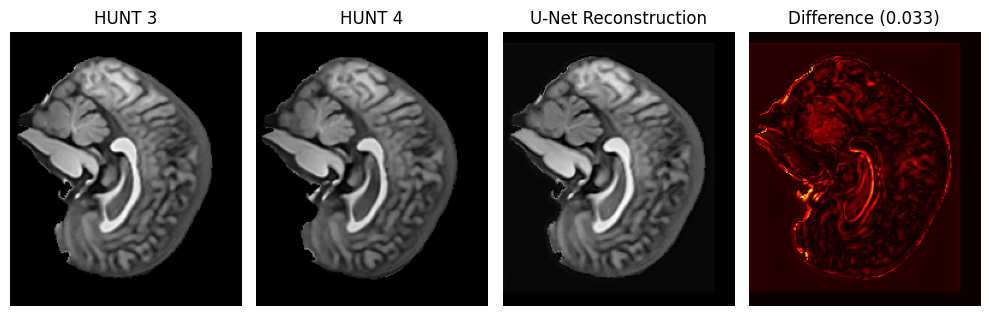

Displaying snapshot from pair 200, loss: 0.1583


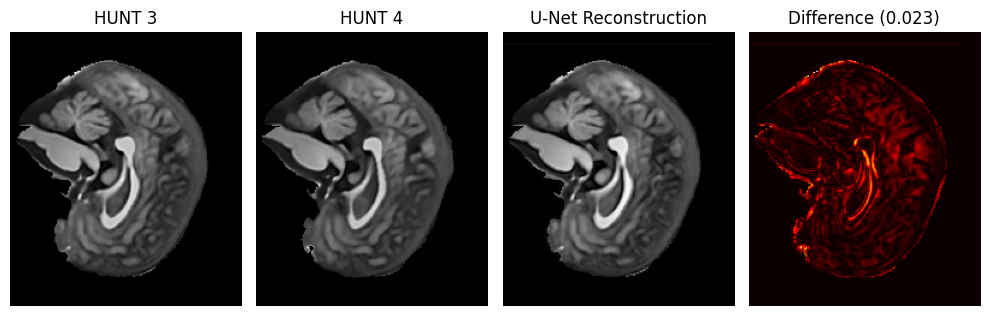

Displaying snapshot from pair 249, loss: 0.1142


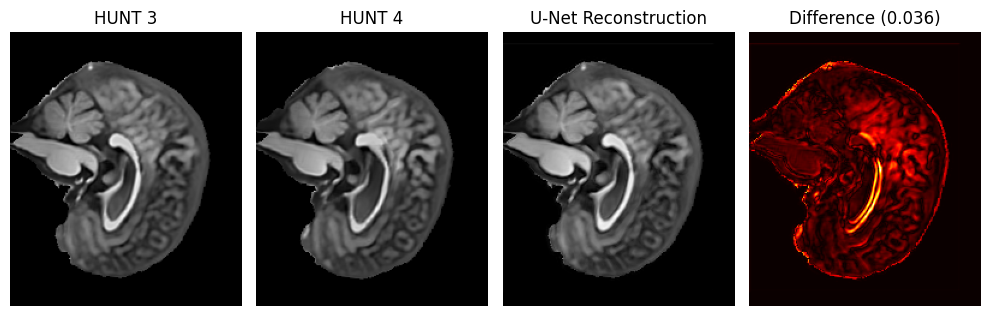

In [ ]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_analyser.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [ ]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unets/3d_res_unet_model.pt


### Model Evaluation over Testset

In [ ]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_res_unet_model.pt"

# Import model before testing
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet.load_state_dict(torch.load(unet_path))
print("Loaded trained model for testing.")

Loaded trained model for testing.


In [ ]:
unet.eval()
avg_unet_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input_full, target_full = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    input, target = data_converter.get_volume_with_3d_change(tensor=input_full, crop_axes=img_crop_axes, remove_mode=True), data_converter.get_volume_with_3d_change(tensor=target_full, crop_axes=img_crop_axes, remove_mode=True)

    # Get Reconstructions
    unet_recon, _ = unet(input)
    target_num = target

    # calculate 3d loss
    avg_unet_loss += ssim_loss(unet_recon, target_num).item()

avg_unet_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")

# We save the model with the test loss in the filename for easy identification
test_unet_path = f"{output_dir}/3d_unet_model_standard_testloss_{avg_unet_loss:.4f}.pt"
torch.save(unet.state_dict(), test_unet_path)
print(f"Test model saved to {test_unet_path}")

100%|██████████| 106/106 [00:50<00:00,  2.09it/s]

Average U-Net 3D Loss over Test Set: 0.0143
Test model saved to out/unets/3d_unet_model_standard_testloss_0.0143.pt


In [ ]:
# Display some test results
num_display = 3
slice_position = 60

for i in range(num_display):
    input_path, target_path = random.choice(test_pairs)
    input_full, target_full = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    red_input = data_converter.get_volume_with_3d_change(tensor=input_full, crop_axes=img_crop_axes, remove_mode=True)
     
    unet_recon = unet(red_input)[0]
    unet_recon_full = data_converter.get_volume_with_3d_change(tensor=unet_recon.unsqueeze(0).unsqueeze(0), crop_axes=img_crop_axes, remove_mode=False).squeeze()
    unet_recon = unet_recon_full.detach().cpu().numpy()[slice_position]

    x = input[0,0].detach().cpu().numpy()[slice_position]
    y = target[0,0].detach().cpu().numpy()[slice_position]
    difference = np.abs(unet_recon - y)
    data_analyser.display_slices([x, y, unet_recon, difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

ValueError: operands could not be broadcast together with shapes (229,193) (208,176) 